# Inverse Problem in Imaging

- **Authors:** Elodie Ferrand & Jules Gomel ; **Teacher:** Pierre Weiss, CNRS  

- **Academic Year:** 2023-24 ISAE-Supaero ; **Course:** Image Acquisition and Processing

**Last Version:** 13 March 2024 

![inverse problem image](img/deepinv_schematic.png) 
**Inverse problem in imaging summary**. Source : [Deepinv website](https://deepinv.github.io/deepinv/)

# 🎯 Outcomes of This Notebook

After working through this notebook, you will be able to:

1. 🧠 Utilize DeepInv to address inverse problems using pretrained models,
2. 🌐 Tackle diverse imaging challenges by engaging with various problems within the realm of imaging, showcasing the application of inverse problem-solving techniques,
3. 📊 Apply equations introduced in class to solve specific problems related to image acquisition and processing.



## Imports & Sanity Check

Please install the requirements files using a virtual environment to avoid any conflict : 

1. Create the virtual environment `python -m venv venv`
2. Activate it `.\venv\Scripts\activate`
3. Install the required packages `pip install -r requirements.txt`

In [2]:
import deepinv as dinv
import torch
import matplotlib.pyplot as plt

from deepinv.utils.plotting import plot

from deepinv.utils import load_url_image
from functions.load_image import local_image_to_tensor

In [2]:
# Pytorch GPU sanity check
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.0.1+cu117
11.7
True


---

## Inpainting in Image Processing

🎨 *Inpainting* is a technique used in image processing to **reconstruct missing or damaged parts** of an image. It is particularly useful for repairing damaged photographs or removing unwanted objects from an image. The goal of inpainting algorithms is to fill in the missing regions of an image in a *visually plausible* manner, such that the completed image appears *seamless and natural*.

- ❓ One common approach to inpainting is to use information from the surrounding areas of the missing regions to infer and reconstruct the missing pixels. This can be achieved through various methods, including image-based techniques such as texture synthesis, as well as more sophisticated deep learning-based approaches.

- 🧠 Deep learning-based inpainting methods, such as those implemented in DeepInv, leverage the power of **convolutional neural networks** (CNNs) to learn the mapping between the observed parts of the image and the missing regions. By training on large datasets of images with known missing regions, these models can learn to generate high-quality inpainted images that closely match the surrounding context.

🚀 In this section, we will explore the concept of **inpainting using DeepInv**, a deep learning-based framework for image inpainting. We will learn how to use DeepInv to inpaint missing regions of images and explore its applications in various image restoration tasks.

- 🔥 We will use PyTorch so we need to be sure our GPU will be (wisely!) used ☺

In [3]:
# Set the device to be used
device = torch.device("cuda:0")  if torch.cuda.is_available() else "cpu"
print(device)

# Let's set the seed for reproducibility
seed = torch.manual_seed(0)

cuda:0


🖼️ Let's choose and load an image ! What about a royalty-free platypus ?

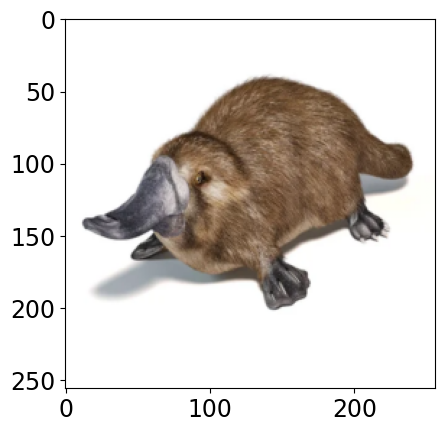

In [7]:
x = local_image_to_tensor('img/royalty_free_platypus.jpg')
plt.imshow(x[0].numpy().transpose(1, 2, 0))
x = x.to(device)

🧑‍🔬 DeepInv uses a class called ```Physics``` to model problems : it instantiates a physics problem to generate the measurements for our inverse problem. Differents problems are grouped in ```deepinv.physics```, including ```Inpainting```. 

- We will instantiate an ```Inpainting``` class with a fixed mask and a ```GaussianNoise``` class to model the problem and the noise respectively.

In [ ]:
# Noise level
sigma = 0.1  

# Create the physics model
physics = dinv.physics.Inpainting(mask=0.5, tensor_size=x.shape[1:], device=device)
physics.noise_model = dinv.physics.GaussianNoise(sigma=sigma)

# Generate the measurements
y = physics(x)


- Let's plot our images and see what we get! 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


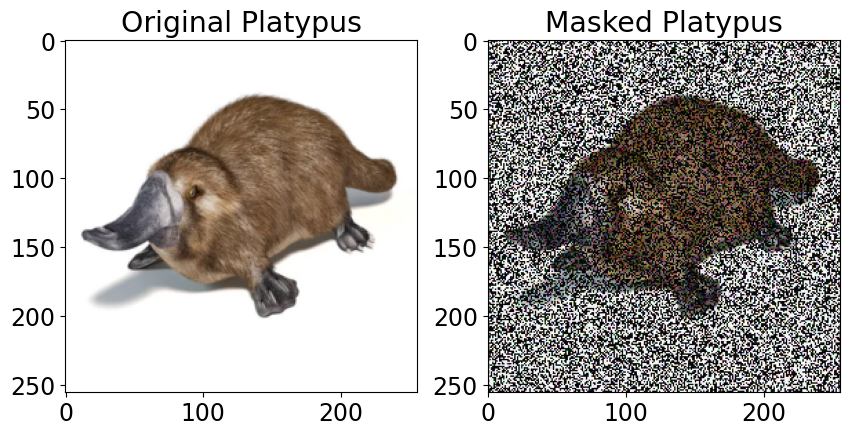

In [22]:
# Let's plot our images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x[0].cpu().numpy().transpose(1, 2, 0))
ax[0].set_title('Original Platypus')
ax[1].imshow(y[0].cpu().numpy().transpose(1, 2, 0))
ax[1].set_title('Masked Platypus')
plt.show()

- Our image is masked as we wanted, perfect ! Now we can instantiate our model to do the inverse problem. 

In [25]:
# Constants

iterations = 1000

lr = 1e-2  # learning rate for the optimizer.
channels = 64  # number of channels per layer in the decoder.
in_size = [2, 2]  # size of the input to the decoder.

# Create the backbone model
backbone = dinv.models.ConvDecoder(
    img_shape=x.shape[1:], in_size=in_size, channels=channels
).to(device)

# Create the deep image prior model
f = dinv.models.DeepImagePrior(
    backbone,
    learning_rate=lr,
    iterations=iterations,
    verbose=True,
    input_size=[channels] + in_size,
).to(device)

100%|██████████| 1000/1000 [00:28<00:00, 34.77it/s]


Linear reconstruction PSNR: 4.27 dB
DIP PSNR: 27.80 dB


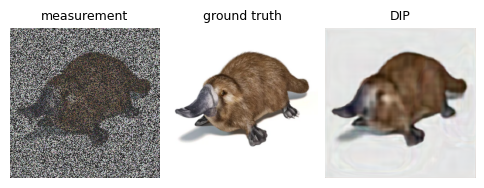

In [26]:
dip = f(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(f"DIP PSNR: {dinv.utils.metric.cal_psnr(x, dip):.2f} dB")

# plot results
plot([x_lin, x, dip], titles=["measurement", "ground truth", "DIP"])